## Propensity Score Matching
### 1. Concept

**PSM** constitutes a powerful technique in the context of observational studies. It aims to improve the study design by identifying the best comparable observational units (e.g., individuals, schools, companies etc.) to be included in the investigation. This capability is highly relevant because it permits observational studies to resemble one of the most important characteristics of purely experimental designs: **Random allocation of observational units to treatment conditions** (e.g., the levels of an independent variable). 

In a **RCT** study, often thought of as the gold standard approach to estimate treatment effects, the influence of potential confounders is reduced by random allocation of observational units to treatment conditions. This ensures that in each intervention group (e.g. therapy and control), relevant variables that might significantly explain variance in an outcome variable are balanced between the groups, thus minimizing their explanatory power across groups. In our example, we aim to compare individuals in terms of their facial emotion recognition performance. However, the literature suggests that fluid intelligence, biological sex and age are significantly related to this outcome variable. If one of the two groups were formed by individuals who are in general more intelligent, older, and mostly females, conclusions drawn in regard to the impact of an independent variable would not be **reliable** because observed differences in the dependent variable might have been caused by sex, intelligence or age (confounder effects). By randomly allocating participants to either group, we expect these variables to be balanced across the groups and therefore, not to have an effect on group differences on the outcome variable. Great! We have a chance to increase the **internal validity** of our experiment by minimizing the role of external variables (confounders). The problem is that in evaluation research, it is rarely possible to assign units to treatment groups by a random allocation. 

In fact, evaluation research normally deals with scenarios in which groups are already constituted, for instance when comparing classes within a school, individuals from different companies or when investigating **subject variables**. That is, if we want to compare participants with and without an autism disorder diagnostic, it would not make sense to randomly allocate participants in a control group and an intervention group, as the intervention group is by definition, formed by participants with autism disorder. **PSM** allows us to create different groups in which the effect of confounders is minimized by matching observational units accounting for covariates. In brief, **PSM** yields treatment groups that are equivalent in a set of relevant variables, in our example, biological sex, age and fluid intelligence. 

**Propensity scores** are **probabilities** of treatment assignment given covariate values at baseline. They are said to be balancing scores because conditional on them, the covariates' distributions are similar across groups. This means that in a set of individuals with similar propensity scores, the covariates' distributions are similar in the control and intervention groups.  

Let us see how it works. First, let us load our data again and perform some preprocessing:

In [15]:
#######################################################
## Specify R environment for rpy2
#import os
#os.environ['R_HOME'] = r'C:\Program Files\R\R-4.4.3'  # Replace with your R path
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects import Formula
import contextlib
# Ipython extension for plotting
%load_ext rpy2.ipython
########################################################

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import pingouin as pg


# Read the CSV file using a relative path
## Data frame
AU = pd.read_csv(f"../PSM/Datasets/AU.txt", sep="\t", escapechar='"', skipinitialspace=True)
KG = pd.read_csv(f"../PSM/Datasets/KG.txt", sep="\t", escapechar='"', skipinitialspace=True)

# Combine the AU and KG datasets
au_data = pd.concat([AU, KG], ignore_index=False)

# Select specific columns
au_data = au_data[["Gruppe", "Geschlecht", "Subject_id", "Alter", "Gminiq3"]]

# Remove rows with missing values
au_data = au_data.dropna()

# Rename the columns
au_data.columns = ["group", "b_sex", "Subject_id", "age", "f_inte"]

# Convert the 'group' column to numeric
au_data["group"] = pd.to_numeric(au_data["group"])

# Add an ID column
au_data['id'] = range(au_data.shape[0])

# Display the first few rows of the processed data
print(au_data.head())
print(f"Shape of the processed data: {au_data.shape}")

# Save the processed data to a CSV file
au_data.to_csv(f"../PSM/Datasets/au_data.csv", index=False)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
   group  b_sex  Subject_id   age  f_inte  id
0      1      0       10001  12.0      28   0
1      1      0       10002   8.0      19   1
2      1      0       10003  13.0      27   2
3      1      1       11004  12.0      24   3
4      1      1       11005  14.0      41   4
Shape of the processed data: (166, 6)


### 2. Between-group differences

In our example, we are concerned that differences in intelligence might interfere with the effect of the novel therapy on facial emotion recognition. For illustrative purposes we will briefly investigate whether such significant differences exist:

Can you think of an easy way to test whether the two groups differ with respect to fluid intelligence? 
A simple ANOVA (or simply t-test when having only two groups) will answer this question. Use the next code chuck to run an ANOVA considering the kind of design that you have (e.g., within subjects?). Feel free to use any of the functions that you learned during the first tutorials.

In [14]:
# Perform one-way ANOVA
anova_results = pg.anova(dv='f_inte', between='group', data=au_data, detailed=True)

# Print the ANOVA results
print("One-Way ANOVA Results:")
print(anova_results)


One-Way ANOVA Results:
   Source            SS   DF          MS         F     p-unc       np2
0   group    913.634763    1  913.634763  9.458538  0.002463  0.054529
1  Within  15841.359213  164   96.593654       NaN       NaN       NaN


### 3. Interpretation


This table breaks down the sources of variance in the data to determine if there's a statistically significant difference between the means of general intelligence.

#### **Columns: Statistical Values**

* **`SS` (Sum of Squares)**: This represents the total amount of variation for a given source.
    * `SS group` = **913.63**: The total variation that is explained by the differences between the group means.
    * `SS Within` = **15041.36**: The total variation within the groups that is *not* explained by group membership (the error).

* **`DF` (Degrees of Freedom)**: The number of independent values used to calculate the statistic.
    * `DF group` = **1**: Calculated as `(number of groups - 1)`. A value of 1 means you were comparing **two** groups.
    * `DF Within` = **164**: Calculated as `(total number of participants - number of groups)`. This means we had **166** total participants in your analysis (164 + 2 groups).

* **`MS` (Mean Square)**: The average amount of variance. It is calculated as `SS / DF`.
    * `MS group` = **913.63**: The average variance *between* your groups (`913.63 / 1`).
    * `MS Within` = **96.59**: The average variance *within* your groups (`15841.36 / 164`).

* **`F` (F-statistic)**: The final test statistic for ANOVA. It is the ratio of the variance between groups to the variance within groups (`MS group / MS Within`).
    * `F` = **9.45**: Your calculated value (`913.63 / 96.59`). This result shows that the variance explained by the group differences is **9.45 times larger** than the unexplained variance within the groups.

* **`p-unc` (p-value, uncorrected)**: The probability of obtaining an F-statistic this large or larger purely by random chance, assuming there is no real difference between the groups (the null hypothesis).
    * `p-unc` = **0.002463**: This extremely low probability (about 0.25%) is well below the standard threshold of 0.05 (5%), leading to the conclusion that your result is **statistically significant**.

* **`np2` (Partial Eta Squared, $η_p^2$)**: This is the effect size. It measures the proportion of variance in the outcome that is explained by the group membership.
    * `np2` = **0.095**: This means that **9.5%** of the total variance in your outcome variable is directly associated with the independent variable ('group'). This is typically considered a **medium-to-large effect size**, indicating the finding is not just statistically significant but also practically meaningful.

### 4. PSM Computation

In order to conduct PSM, we can use the `matchit()` function from the `MatchIt` package in R.

R Code for Propensity Score Matching using matchit

`m.out = matchit(ov ~ mv1 + mv2 + mv13 + ..., data = data, ratio=1, method = "nearest", distance = "glm")`

---

### Parameter Explanations

* **`ov`**: Origin or grouping variable. This is the treatment variable that defines the groups (e.g., intervention vs. control). In the formula, this is the variable on the left side of the `~`.
* **`mv`**: Matching Variables. These are the covariates (`mv1`, `mv2`, etc.) based on which you want to form equivalent groups. In the formula, these are the variables on the right side of the `~`.
* **`data`**: The data frame object that contains all the specified variables.
* **`distance`**: The method used to estimate the propensity scores. `"glm"` uses a generalized linear model (logistic regression by default) to predict the probability of being in the treatment group.
* **`method`**: The algorithm for matching units based on their propensity scores. `"nearest"` performs nearest neighbor matching, where one or more control units are matched to each treated unit based on the smallest distance.

In [16]:
# Activate the pandas2ri conversion
pandas2ri.activate()

# Import the MatchIt package
matchit = importr('MatchIt')

# Put the data into the R environment
ro.globalenv['au_data'] = pandas2ri.py2rpy(au_data)

# Perform propensity score matching in R
ro.r('''
    library(MatchIt)
    m_out <- matchit(group ~ f_inte + b_sex + age, data = au_data, method = "nearest", distance = "glm", ratio = 1)
''')

# Summarize the matching results in R
m_out_summary = ro.r('summary(m_out)')

# Print the summary
print(m_out_summary)


Call:
matchit(formula = group ~ f_inte + b_sex + age, data = au_data, 
    method = "nearest", distance = "glm", ratio = 1)

Summary of Balance for All Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance        0.2483        0.1525          0.7675     1.8190    0.2206
f_inte         26.7857       33.0507         -0.5483     1.4521    0.1496
b_sex           0.2857        0.4855         -0.4423          .    0.1998
age            12.9286       13.4493         -0.1868     2.1549    0.0679
         eCDF Max
distance   0.4120
f_inte     0.3949
b_sex      0.1998
age        0.1853

Summary of Balance for Matched Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance        0.2483        0.2419          0.0518     1.1635    0.0076
f_inte         26.7857       26.8929         -0.0094     1.2805    0.0349
b_sex           0.2857        0.3214         -0.0791          .    0.0357
age            12.9286       13.0357         -0

### 5. Output interpretation


#### 1. Sample Sizes: Before and After Matching

This section shows the direct result of the matching algorithm.

* **`All`**: This is the starting point. The original dataset was imbalanced in size, with **138 Control** participants and only **28 Treated** participants.
* **`Matched`**: This is the final dataset for analysis. 
* **`Unmatched`**: These are the participants who were not selected for the final analysis. **110** control participants were left out because their characteristics (summarized by the propensity score) were not close enough to any of the treated individuals.

---

#### 2. A Guide to the Balance Metrics

* **`Std. Mean Diff.` (Standardized Mean Difference):** The most important metric. It measures the difference in means between the two groups, scaled by the standard deviation. **Goal: Get this value as close to 0 as possible.** A common rule of thumb considers a value > |0.1| to indicate a meaningful imbalance.
* **`Var. Ratio` (Variance Ratio):** The ratio of the variance in the treated group to the control group. It measures if the *spread* of the data is similar. **Goal: Get this value close to 1.0.**
* **`eCDF Mean` & `eCDF Max` (Empirical CDF Statistics):** The eCDF represents the entire distribution of a variable. These stats measure the average (`Mean`) and maximum (`Max`) difference between the distribution curves of the two groups. They are a more robust check than just comparing means. **Goal: Get these values close to 0.**
* **`Std. Pair Dist.` (Standardized Pair Distance):** Appears only *after* matching. It is the average difference in the propensity scores for the matched pairs. **Goal: A small value**, which indicates that the matched individuals were indeed very similar on their overall profile.

---

#### 3. Balance Assessment: Before Matching (`All Data`)

This table confirms the initial groups were not comparable.

* **`f_inte` (Intelligence):** A severe imbalance is shown by the large `Std. Mean Diff.` of **-0.5483**. The high `eCDF Mean` of **0.1496** confirms the entire distributions were very different.
* **`b_sex` (Sex):** A severe imbalance with a `Std. Mean Diff.` of **-0.4423**.
* **`age`:** A moderate imbalance with a `Std. Mean Diff.` of **-0.1868**. The `Var. Ratio` of **2.1549** also shows that the variance (spread) of age was more than twice as large in the treated group as in the control group.

**Conclusion Before Matching:** The groups were significantly different across all covariates, making a direct comparison unreliable.

---

#### 4. Balance Assessment: After Matching (`Matched Data`)

This table demonstrates the success of the matching procedure.

* **`f_inte` (Intelligence):** The `Std. Mean Diff.` was reduced from -0.5483 to an excellent **-0.0094**. The `eCDF Mean` also dropped dramatically from 0.1496 to **0.0349**, showing the entire distributions are now very similar.
* **`b_sex` (Sex):** The `Std. Mean Diff.` was reduced from -0.4423 to a negligible **-0.0791**.
* **`age`:** The `Std. Mean Diff.` was reduced from -0.1868 to an excellent **-0.0384**. The `Var. Ratio` improved from 2.15 to 1.82. While not perfectly 1, this is still a notable improvement in the balance of variances.
* **Pair Distance:** The `Std. Pair Dist.` for the propensity score (`distance`) is **0.1429**, a reasonably small value indicating that the matched pairs were, on average, quite close in their overall profiles.

---

#### 5. Overall Conclusion

The propensity score matching was **successful**.

The procedure effectively created a new control group that is highly comparable to the treated group. This is evidenced by the substantial reduction in the **Standardized Mean Differences** and **eCDF statistics** for all covariates, bringing them to negligible levels. This successful balancing provides a much stronger foundation for making causal inferences, as you can be more confident that any difference found in your outcome is due to the treatment itself, not to these pre-existing confounding variables.

### Exercise

Now, use the cell below to re-do the MatchIt analysis but using differet value of ratio (e.g., 2). Find the differences in the outcomes.

In [5]:
# Perform propensity score matching in R
ro.r('''
    library(MatchIt)
    m_out <- matchit(group ~ f_inte + b_sex + age, data = au_data, method = "nearest", distance = "glm", ratio = 2)
''')

# Summarize the matching results in R
m_out_summary = ro.r('summary(m_out)')

# Print the summary
print(m_out_summary)


Call:
matchit(formula = group ~ f_inte + b_sex + age, data = au_data, 
    method = "nearest", distance = "glm", ratio = 2)

Summary of Balance for All Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance        0.2483        0.1525          0.7675     1.8190    0.2206
f_inte         26.7857       33.0507         -0.5483     1.4521    0.1496
b_sex           0.2857        0.4855         -0.4423          .    0.1998
age            12.9286       13.4493         -0.1868     2.1549    0.0679
         eCDF Max
distance   0.4120
f_inte     0.3949
b_sex      0.1998
age        0.1853

Summary of Balance for Matched Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance        0.2483        0.2189          0.2360     1.5485    0.0403
f_inte         26.7857       28.5357         -0.1532     1.6878    0.0683
b_sex           0.2857        0.3036         -0.0395          .    0.0179
age            12.9286       13.1964         -0

  
### 6. Graphical output
  
In addition to the table-form output, it is possible to graphically inspect the PSM results: 
  
#### A. Distribution of Propensity Scores

The code line below displays the **Propensity Score Distributions** of matched and unmatched control and intervention groups. The first cell, under "Unmatched Treatment Units" is empty because all intervention observations were used for matching. This is not the case for the control group. Note that each dot under "Matched Treatment Units" has a corresponding dot under "Unmatched Treatment Units" (they are "in line"). This is an indication of how the matching procedure worked, meaning that the observations were matched considering their propensity scores. Finally, remember that propensity scores are probability values, so the maximal possible value is 1.

To identify the units, use first mouse button; to stop, use second.


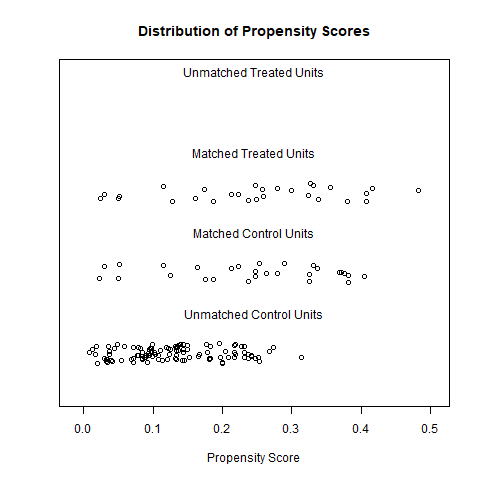

In [17]:
%%R
plot(m_out, type = "jitter")

#### B. Distribution of Propensity Histograms

The `plot` below returns four histograms corresponding to intervention and control groups before and after **PSM**. In general, if the PSM properly worked, we would expect the upper and lower right figures to be more similar than the  upper and lower left figures. In other words, the propensity score distributions should be more similar between the intervention and control groups after PSM.


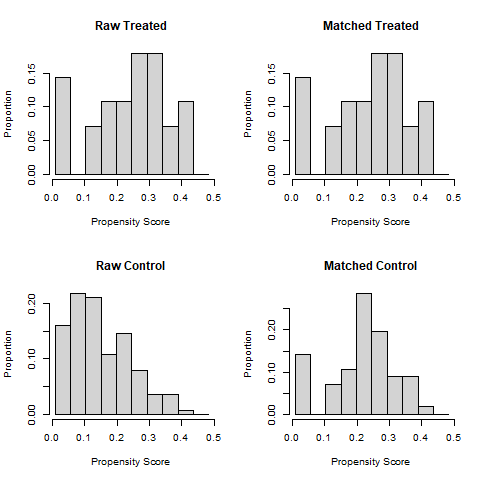

In [7]:
%%R
plot(m_out, type = "hist")

### 7. Output data

We can now extract the data set containing only the observations that have been matched to conduct further analysis: 

We now use the `match.data()` function to extract the data frame that resulted from PSM with ratio = 1. We call the data frame "matched_au". Then inspect the data frame and repeat the ANOVA analysis on fluid intelligence to check whether significant between-group differences remain. 



In [18]:
# Perform match data in R
ro.r('matched_au <- match.data(m_out)')

# Convert the R DataFrame to a pandas DataFrame
matched_au = pandas2ri.rpy2py(ro.r('matched_au'))

# Perform one-way ANOVA using the matched data in Python
anova_results = pg.anova(dv='f_inte', between='group', data=matched_au, detailed=True)

# Print the ANOVA results
print("One-Way ANOVA Results:")
print(anova_results)

One-Way ANOVA Results:
   Source           SS  DF          MS         F     p-unc       np2
0   group     0.160714   1    0.160714  0.001383  0.970477  0.000026
1  Within  6277.392857  54  116.248016       NaN       NaN       NaN


These results demonstrate that after performing PSM the two groups do not significantly differ in fluid intelligence. As such, observed differences in face processing skills are less likely to be explained by it. 